# Ejercicios UMAP 

- Instalar umap-learn y densmap-learn.

- Descargar el dataset de Fashion MNIST del siguiente enlace:
    
    https://github.com/zalandoresearch/fashion-mnist

    Tendrás que descomprimir los ficheros \*gz para que el código funcione. Asegúrate que el path utilizado para cargar los datos sea el correcto.


## 1. UMAP en Fashion MNIST

Primero realizaremos una reducción de dimensionalidad no supervisada mediante UMAP. Estableceremos el número de vecinos en 5 porque estamos interesados solo en la información local. Reduciremos el número de dimensiones a 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from utils import mnist_reader

import umap
sns.set(style='white', context='poster')

train, train_labels = mnist_reader.load_mnist('data/fashion', kind='train')
test, test_labels = mnist_reader.load_mnist('data/fashion', kind='t10k')

data = np.array(np.vstack([train, test]), dtype=np.float64) / 255.0
target = np.hstack([train_labels, test_labels])
classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

%time embedding2 = umap.UMAP(n_neighbors=10).fit_transform(data)

CPU times: total: 4min 59s
Wall time: 34.6 s


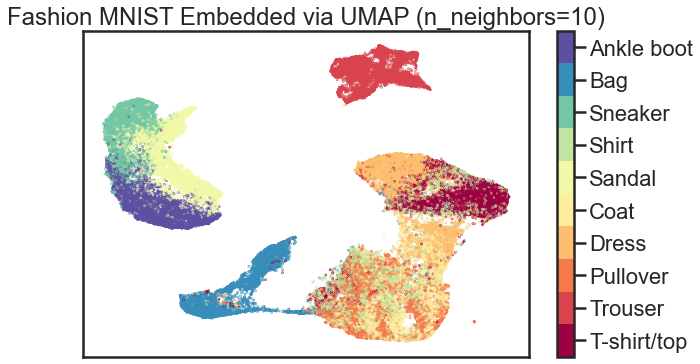

In [4]:
fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*embedding2.T, s=0.3, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP (n_neighbors=10)');



Aplicamos DensMAP para comparar los resultados con el algoritmo UMAP clásico.

CPU times: total: 0 ns
Wall time: 0 ns


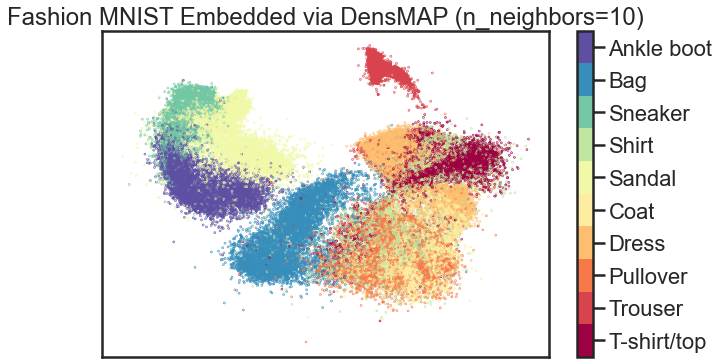

In [5]:
%time
mapper = umap.UMAP(densmap=True, n_neighbors=10).fit(data)

fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*mapper.embedding_.T, s=0.3, c=np.array(target), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via DensMAP (n_neighbors=10)');

## 2. Utilizando etiquetas para separar clases (Supervised UMAP)

Para realizar esta versión supervisada de UMAP introduciremos las etiquetas en el parámetro 'y' de la función 'fit' de UMAP. En este caso se utilizará un número mayor de vecinos (podemos poner 15). UMAP también permite hacer hacer aprendizaje semi-supervisado.

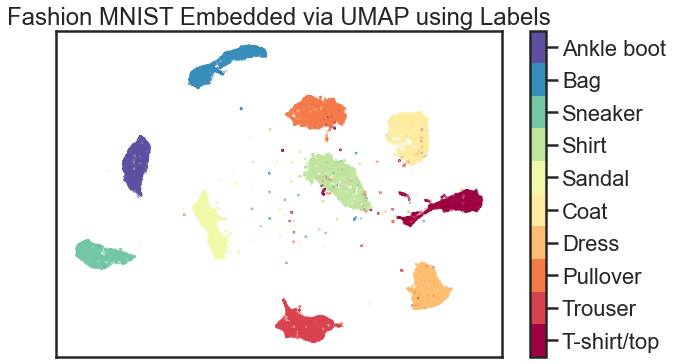

In [7]:
embedding = umap.UMAP(n_neighbors=15).fit_transform(data, y=target)

fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*embedding.T, s=0.1, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP using Labels');

Aplicamos el algoritmo DensMAP para comparar con el UMAP clásico.

CPU times: total: 0 ns
Wall time: 0 ns


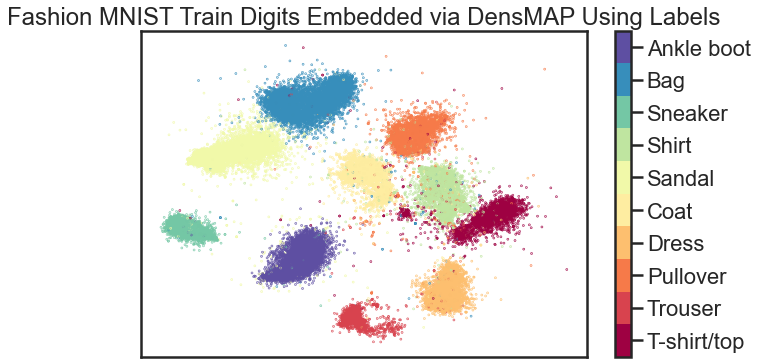

In [8]:
%time
mapper = umap.UMAP(densmap=True, n_neighbors=15).fit(data, np.array(target))

fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*mapper.embedding_.T, s=0.3, c=np.array(target), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Train Digits Embedded via DensMAP Using Labels');

## 3. Entrenamiento con etiquetas y embedding con test no etiquetado (Metric Learning with UMAP)

Veamos como se puede utilizar UMAP en aprendizaje métrico, es decir, aprender un embedding supervisado de los datos y utilizar datos nuevos para clasificar a partir de una métrica aprendida como una medida de la distancia entre nuevos puntos no etiquetados. Este procedimiento no lo podemos aplicar con DensMAP porque DensMAP no permite transformar datos a un "embedding" entrenado con otro dataset (train), por lo que utilizarem UMAP clásico. 

Para ello utiliza la división entre train y test proporcionada por Fashion MNIST y visualiza los resultados.

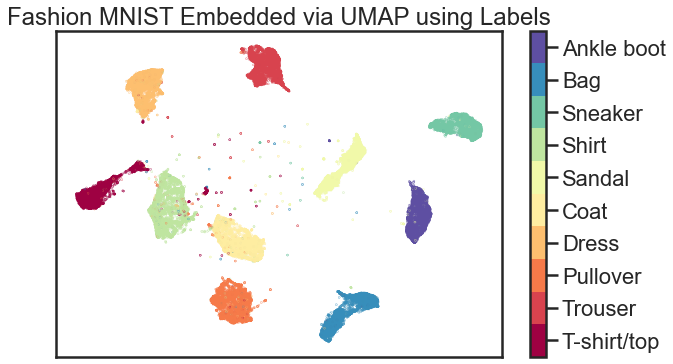

In [12]:
model = umap.UMAP(n_neighbors=15)

embedding = model.fit_transform(train, y=train_labels)

fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*embedding.T, s=0.1, c=train_labels, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Embedded via UMAP using Labels');

CPU times: total: 0 ns
Wall time: 0 ns


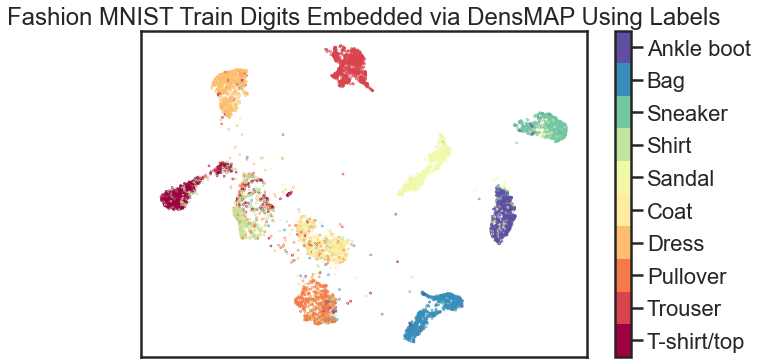

In [14]:
%time
mapper = model.transform(test)

fig, ax = plt.subplots(1, figsize=(10, 6))
plt.scatter(*mapper.T, s=0.3, c=np.array(test_labels), cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Fashion MNIST Train Digits Embedded via DensMAP Using Labels');

## 4. Agrupamiento (clustering)

UMAP puede utilizarse para el preprocesado de datos para mejorar el desempeño de algoritmos de clustering basados en la densidad. A pesar de que UMAP no mantiene completamente la densidad del conjunto de datos, siguen habiendo razones válidas para usar UMAP para el preprocesado previo al agrupamiento. 

1. Representa el `adjusted_mutual_info_score` en función del `número de vecinos` en el embedding (entre 4 y 10 de 2 en 2) y el `min_dist` (3 puntos entre 0 y 1).
2. Representa el resultado del embedding de la mejor combinación de parámetros.

Utiliza un K-Means con 10 clusters, ya que sabemos de antemano el número de clusters en los que se divide el conjunto de datos.

In [17]:
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import KMeans
import numpy as np
import umap

nn=np.arange(4,11,2)
dist = np.arange(0,1.5,0.5)
adjusted_mutual_info_score_=np.zeros((len(nn), len(dist)))

for i,n in enumerate(nn):
    for j, di in enumerate(dist):
        print('Neighbours: %d, Min_dist:%0.2f' %(n,di))
        clusterable_embedding = umap.UMAP(n_neighbors=n, min_dist=di).fit(train, np.array(train_labels))
        test_embedding = clusterable_embedding.transform(test)
        
        kmeans_labels = KMeans(n_clusters=10, n_init='auto', random_state=42).fit_predict(test_embedding)
        adjusted_mutual_info_score_[i,j]=adjusted_mutual_info_score(test_labels, kmeans_labels)

Neighbours: 4, Min_dist:0.00


TypeError: '<=' not supported between instances of 'str' and 'int'